In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
from os import listdir
from os.path import isfile, join
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix
import multiprocessing

In [5]:
mypath = '../../data/MLgSA/wss/'
mypath1 = '../../data/MLgSA/New_wss/'

onlyfiles = np.asarray([f for f in listdir(mypath) if isfile(join(mypath, f))])
onlyfiles1 = np.asarray([f for f in listdir(mypath1) if isfile(join(mypath1, f))])

onlyfiles.sort()
onlyfiles1.sort()

print(len(onlyfiles), len(onlyfiles1))

short_list = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles])
short_list1 = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles1])
# short_list = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles])

108 30


In [6]:
df = pd.read_csv("../../data/MLgSA/stenosis_metadata.csv", sep=';')
# Matching the stenosis degree to the datasets
# missing datasets : index = [68, 87, 106]
df = df.drop(index=[68, 87, 106])
degree_list = df['ID'].values

In [7]:
meshes = []

for f in onlyfiles:
    reader = pv.get_reader(mypath + f)
    meshes.append(reader.read())
    
for f in onlyfiles1:
    reader = pv.get_reader(mypath1 + f)
    meshes.append(reader.read())

In [29]:
# data stats
dl = []

for mesh in meshes:
    dl.append(np.asarray(mesh.point_data.values()[1]))

data = np.concatenate(dl)
mins = np.min(data)
maxs = np.max(data)
print(mins, maxs, maxs - mins)

1.5448250238086984e-06 1674.871828135934 1674.871826591109


In [35]:
def get_graph(mesh):
    node_array = mesh.points
    n = node_array.shape[0]
    rows = []
    cols = []
    
    features = (np.asarray(mesh.point_data['non-directional_WSS_@_t=1.1']).T - mins)/(maxs - mins)

    for i in range(mesh.number_of_cells):
        cell = mesh.get_cell(i)
        cell_points = cell.point_ids
        n_points = len(cell_points)
        for j in range(n_points):
            for k in range(j + 1, n_points):
                p1 = cell_points[j]
                p2 = cell_points[k]
                rows.append(p1)
                cols.append(p2)
                rows.append(p2)
                cols.append(p1)  


    adj_matrix_coo = coo_matrix((np.ones(len(rows)), (rows, cols)), shape=(mesh.number_of_points, mesh.number_of_points))
    edges = list(zip(adj_matrix_coo.row, adj_matrix_coo.col))
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    
    
    return edge_index, n, features

In [36]:
edjl = []
numl = []
nf = []

p = multiprocessing.Pool(8)

for j, m in enumerate(meshes):
    edj, num, fe = get_graph(m)
    edjl.append(edj)
    numl.append(num)
    nf.append(fe)

p.close()
p.join()


In [39]:
torch.save(edjl, '../../data/MLgSA/edge_indices.pt')
torch.save(numl, '../../data/MLgSA/nodes.pt')
torch.save(nf, '../../data/MLgSA/node_features.pt')

In [41]:
data_list = torch.load('../../data/MLgSA/export/old/dataset.pt')
ys = [pt.y for pt in data_list]

In [58]:
len(nf)

138

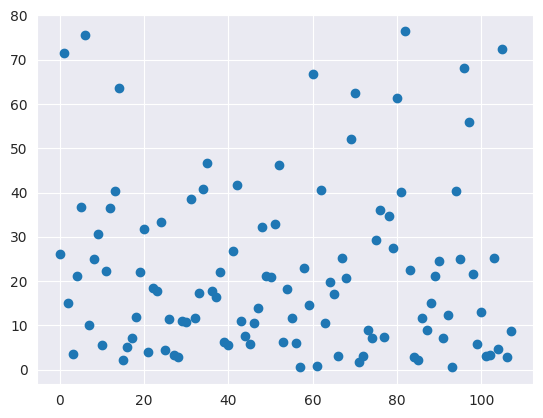

In [45]:
plt.scatter(range(108), ys)

In [56]:
sum(y > 50 for y in ys)

11

In [59]:
new_ys = []

for i in range(138):
    if i < 108:
        new_ys.append(0) if ys[i] < 50 else new_ys.append(1)
    else:
        new_ys.append(1)

In [62]:
torch.save(new_ys, '../../data/MLgSA/classes.pt')